In [1]:
import numpy as np
import matplotlib as mpl
import collections
import copy
from qbstyles import mpl_style
import gym
from gym import spaces
import or_gym
from or_gym.utils.env_config import *
from or_gym.algos.rl_utils import create_env
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
mpl_style(dark=False)

In [2]:
class InvManagementMaster(gym.Env):
    
    def __init__(self, demand=None, *args, **kwargs):
        
        self.step_limit = 30
        self.initial_inventory = np.array([100, 100, 200])
        self.unit_price = np.array([2, 1.5, 1, 0.75])                                       # p
        self.unit_cost = np.array([1.5, 1.0, 0.75, 0.5])          # r
        self.backlog_cost = np.array([0.1, 0.075, 0.05, 0.025])   # k
        self.holding_cost = np.array([0.15, 0.1, 0.05])           # h
        self.supply_capacity = np.array([100, 90, 80])            # c
        self.lead_times = np.array([3, 5, 10])                    # L
        self.backlog = True
        self.dist = 1
        self.dist_param = {'mu': 20}
        self.alpha = 0.97
        self.seed_int = 0
        self.user_dist = np.zeros(self.step_limit)
        self.num_stages = len(self.initial_inventory) + 1
        
        self.demand_dist = stats.poisson
        self.seed(self.seed_int)
        if demand is not None:
            self.demand_dist = demand
            self.custom_demand = True
        else:
            self.custom_demand = False
        
        self.action_space = spaces.Box(
            low=np.zeros(self.num_stages-1), high=self.supply_capacity, dtype=np.int16)
        self.observation_space = spaces.Box(
            low=-np.ones(self.num_stages-1)*self.supply_capacity.max()*self.step_limit*10,
            high=self.supply_capacity*self.step_limit)
        
        self.reset()
        
    def seed(self, seed=None):
        if seed != None:
            np.random.seed(seed=int(seed))

    def reset(self):
        self.current_step = 0
        self.inventory_levels = np.zeros((self.step_limit, 
            self.num_stages-1), dtype=np.int16)
        self.inventory_levels[0] = self.initial_inventory.copy()
        self.inventory_in_transit = self.inventory_levels.copy()
        self.backlog_orders = np.zeros((self.step_limit,
            self.num_stages), dtype=np.int16)
        self.retail_demand = np.zeros(self.step_limit)
        self.profits = self.retail_demand.copy()
        self.recievables = self.inventory_in_transit.copy()
        self.order_history = np.zeros((self.step_limit, self.num_stages-1))
        self.state = self.initial_inventory.copy()
        return self.state

    def step(self, action):
        action = np.maximum(action, 0).astype(int)
        t = self.current_step
        self.order_history[t] = action.copy()
        current_inventory = self.inventory_levels[t].copy()
        current_backlog = self.backlog_orders[t].copy()
        shipments = np.zeros(self.num_stages)
        # Receive inventory in transit
        for i in range(self.num_stages - 1):
            if t - self.lead_times[i] >= 0:
                current_inventory[i] += self.inventory_in_transit[t - self.lead_times[i], i]
                self.recievables[t, i] += self.inventory_in_transit[t - self.lead_times[i], i]

        # Sell retail demand
        retail_demand = np.random.poisson(lam=20)
#         retail_demand = self.demand_dist.rvs(**self.dist_param)
        
        total_demand = current_backlog.copy()
        total_demand[0] += retail_demand
#         for i, a in enumerate(action, 1):
#             total_demand[i] += a
        total_demand[1:] += action
        shipments[-1] = total_demand[-1] # Add capacity limit at this stage
        for i in range(self.num_stages - 1):
            if current_inventory[i] >= total_demand[i]:
                shipments[i] += total_demand[i]
                current_inventory[i] -= total_demand[i]
                current_backlog[i] = 0
            else:
                current_backlog[i] = total_demand[i] - current_inventory[i]
                shipments[i] += current_inventory[i]
                # Update shipments
                current_inventory[i] = 0
        # Add case for when we use lost sales vs backlog penalty
        reward = np.sum(shipments*self.unit_price) - \
            (np.sum(self.unit_cost*shipments + self.backlog_cost*current_backlog) \
             + np.sum(self.holding_cost*current_inventory))

        
        self.inventory_in_transit[t] = shipments[1:].copy()
        
        self.current_step += 1
        
        done = True if self.current_step >= self.step_limit else False
        
        self.state = current_inventory.copy()
        if not done:
            self.inventory_levels[self.current_step] = current_inventory.copy()
            self.backlog_orders[self.current_step] = current_backlog.copy()
        
        # Log values
        self.retail_demand[t] += retail_demand
        self.profits[t] += reward        
        
        return self.state, reward, done, {}

In [36]:
env = InvManagementMaster()
ep_rewards = []
for i in range(1000):
    s = env.reset()
    R = 0
    done = False
    while done == False:
        valid_obs = env.observation_space.contains(s)
        action = env.action_space.sample()
        valid_action = env.action_space.contains(action)
        s, r, done, _ = env.step(action)
        R += r
        if not valid_obs:
            print("Invalid observation:\t{}".format(s))
        if not valid_action:
            print("Invalid action:\t{}".format(action))
        if done:
            ep_rewards.append(R)

In [37]:
np.mean(ep_rewards), np.min(ep_rewards), np.max(ep_rewards)

(-421.91669999999993, -1331.3, 460.15000000000003)

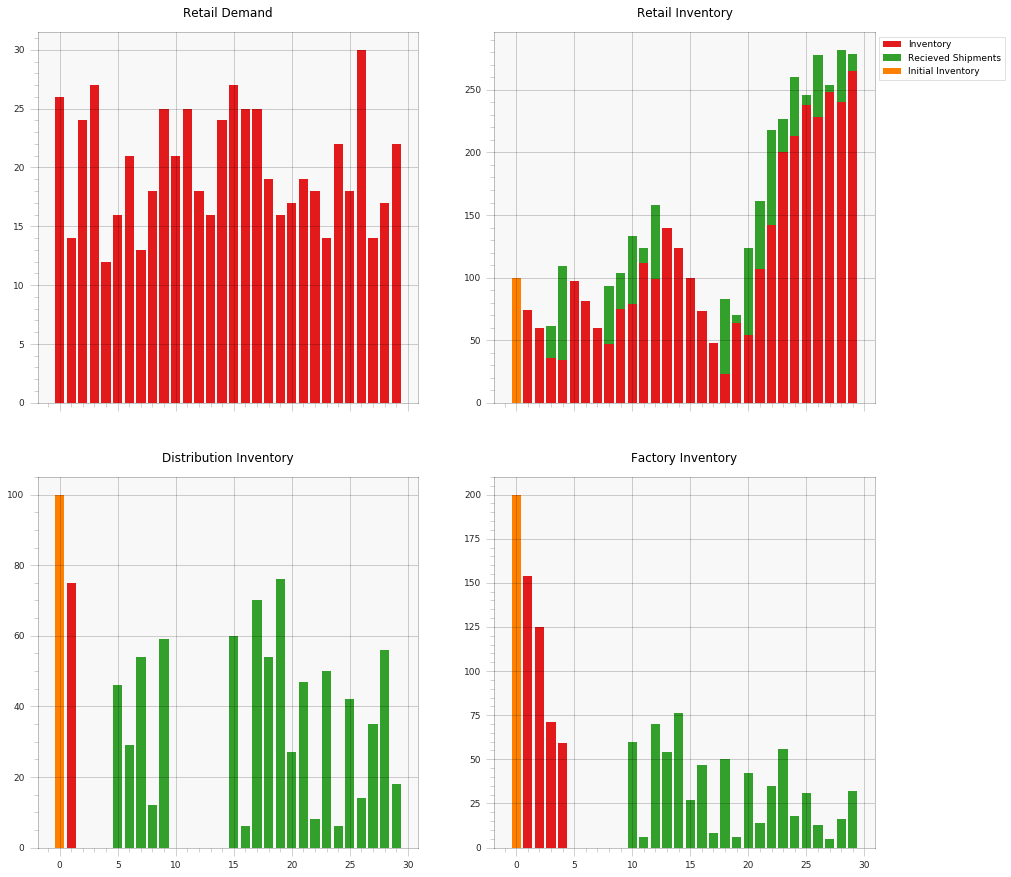

In [6]:
# Plot results
fig, ax = plt.subplots(2, 2, figsize=(15, 15), sharex=True)

ax[0, 0].bar(np.arange(env.step_limit), env.retail_demand)
ax[0, 0].set_title('Retail Demand')

ax[0, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 0], label='Inventory')
ax[0, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 0], 
             bottom=env.inventory_levels[1:, 0], label='Recieved Shipments')
ax[0, 1].bar(0, env.initial_inventory[0], label='Initial Inventory')
ax[0, 1].set_title('Retail Inventory')
ax[0, 1].legend(bbox_to_anchor=[1, 1])

ax[1, 0].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 1], label='Inventory')
ax[1, 0].bar(np.arange(1, env.step_limit), env.recievables[1:, 1], 
             bottom=env.inventory_levels[1:, 1], label='Recieved Shipments')
ax[1, 0].bar(0, env.initial_inventory[1], label='Initial Inventory')
ax[1, 0].set_title('Distribution Inventory')

ax[1, 1].bar(np.arange(1, env.step_limit), env.inventory_levels[1:, 2], label='Inventory')
ax[1, 1].bar(np.arange(1, env.step_limit), env.recievables[1:, 2], 
             bottom=env.inventory_levels[1:, 2], label='Recieved Shipments')
ax[1, 1].bar(0, env.initial_inventory[2], label='Initial Inventory')
ax[1, 1].set_title('Factory Inventory')

plt.show()

# Test with Ray

In [3]:
import ray
from ray.rllib import agents
from ray import tune
from copy import deepcopy
import time

In [4]:
def set_config(default_config, config_dict=None):
    config = deepcopy(default_config)
    if type(config_dict) == dict:
        for k in config.keys():
            if k in config_dict.keys():
                if type(config[k]) == dict:
                    for m in config[k].keys():
                        if m in config_dict.keys():
                            config[k][m] = config_dict[m]
                else:
                    config[k] = config_dict[k]
            else:
                continue
                
    return config

def train_agent(algo='a3c', iters=50, config_dict={}):
    if hasattr(agents, algo):
        agent = getattr(agents, algo)
        config = set_config(agent.DEFAULT_CONFIG, config_dict)
        trainer = getattr(agent, algo.upper() + 'Trainer')(config, 
            env=InvManagementMaster)
#             env=create_env('InvManagement-v0'))
    else:
        raise AttributeError('No attribute {}'.format(algo))
    t0 = time.time()
    results = []
    for n in range(iters):
        t1 = time.time()
        result = trainer.train()
        t2 = time.time()
        print(result['info']['learner'])
        results.append(result)
        if (n + 1) % 10 == 0:
            print("Iter:\t{}\tMean Rewards:\t{:.1f}".format(n+1, result['episode_reward_mean']) + 
                  "\tEps per second:\t{:.3f}\tTotal Time (s):\t{:.1f}".format(
                      result['episodes_this_iter']/(t2-t1), t2-t0))
    
    return trainer, results

In [5]:
ray.init(ignore_reinit_error=True)
trainer, results = train_agent(iters=10)

2020-05-20 13:49:25,233	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-20 13:49:25,235	INFO resource_spec.py:216 -- Starting Ray with 4.1 GiB memory available for workers and up to 2.05 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-20 13:49:25,743	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
2020-05-20 13:49:25,793	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-05-20 13:49:50,860	INFO trainable.py:102 -- _setup took 25.068 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2020-05-20 13:49:50,861	WARNING util.py:45 -- Install gputil for GPU system monitoring.


{'cur_lr': 9.999999747378752e-05, 'policy_loss': -9054.504, 'policy_entropy': 85.37063, 'var_gnorm': 22.976929, 'vf_loss': 72544.61, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.00026381016}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -36835.926, 'policy_entropy': 169.28993, 'var_gnorm': 23.41656, 'vf_loss': 301571.9, 'model': {}, 'grad_gnorm': 39.999996, 'vf_explained_var': 0.0}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -6274.114, 'policy_entropy': 150.84755, 'var_gnorm': 23.393955, 'vf_loss': 12174.562, 'model': {}, 'grad_gnorm': 40.000008, 'vf_explained_var': -0.20346725}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': -2651.7876, 'policy_entropy': 92.53949, 'var_gnorm': 23.761501, 'vf_loss': 6435.041, 'model': {}, 'grad_gnorm': 40.0, 'vf_explained_var': -0.40492666}
{'cur_lr': 9.999999747378752e-05, 'policy_loss': 5239.8145, 'policy_entropy': 122.12816, 'var_gnorm': 24.627165, 'vf_loss': 11171.779, 'model': {}, 'grad_gnorm': 40.000008, 'vf_explained_var': 0.

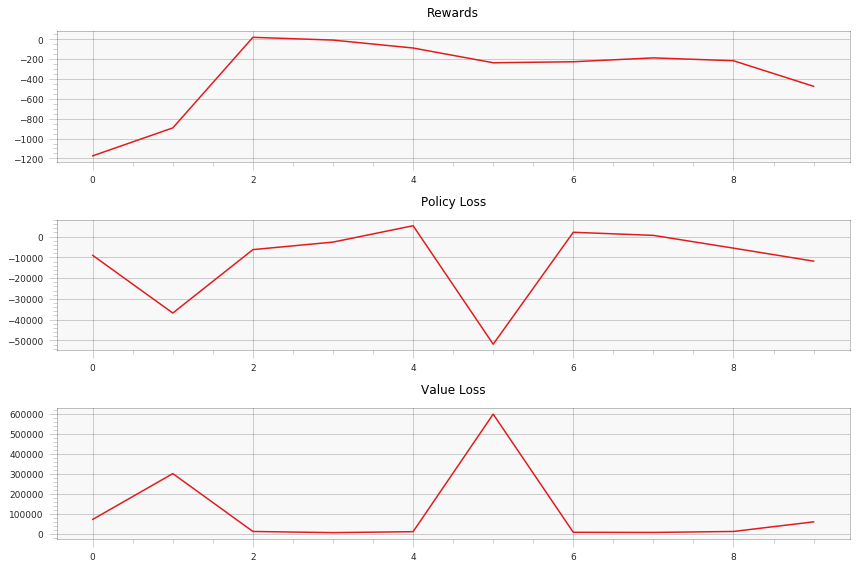

In [6]:
mean_rewards = [i['episode_reward_mean'] for i in results]
policy_loss = [i['info']['learner']['policy_loss'] for i in results]
value_loss = [i['info']['learner']['vf_loss'] for i in results]

fig, ax = plt.subplots(3, 1, figsize=(12,8))
ax[0].plot(mean_rewards)
ax[0].set_title('Rewards')
ax[1].plot(policy_loss)
ax[1].set_title('Policy Loss')
ax[2].plot(value_loss)
ax[2].set_title('Value Loss')
plt.tight_layout()
plt.show()

# Compare to Hector's Environment

In [10]:
trainer.config

{'num_workers': 2,
 'num_envs_per_worker': 1,
 'sample_batch_size': 10,
 'batch_mode': 'truncate_episodes',
 'num_gpus': 0,
 'train_batch_size': 200,
 'model': {'conv_filters': None,
  'conv_activation': 'relu',
  'fcnet_activation': 'tanh',
  'fcnet_hiddens': [256, 256],
  'free_log_std': False,
  'no_final_linear': False,
  'vf_share_layers': True,
  'use_lstm': False,
  'max_seq_len': 20,
  'lstm_cell_size': 256,
  'lstm_use_prev_action_reward': False,
  'state_shape': None,
  'framestack': True,
  'dim': 84,
  'grayscale': False,
  'zero_mean': True,
  'custom_preprocessor': None,
  'custom_model': None,
  'custom_action_dist': None,
  'custom_options': {}},
 'optimizer': {},
 'gamma': 0.99,
 'horizon': None,
 'soft_horizon': False,
 'no_done_at_end': False,
 'env_config': {},
 'env': 'InvManagementBacklogEnv',
 'clip_rewards': None,
 'clip_actions': True,
 'preprocessor_pref': 'deepmind',
 'lr': 0.0001,
 'monitor': False,
 'log_level': 'WARN',
 'callbacks': {'on_episode_start': No

2020-05-14 16:54:14,491	ERROR worker.py:956 -- print_logs: Connection closed by server.
2020-05-14 16:54:14,492	ERROR worker.py:1056 -- listen_error_messages_raylet: Connection closed by server.
2020-05-14 16:54:14,493	ERROR import_thread.py:97 -- ImportThread: Connection closed by server.


(pid=raylet) *** Aborted at 1589493254 (unix time) try "date -d @1589493254" if you are using GNU date ***
(pid=raylet) PC: @                0x0 (unknown)
(pid=raylet) *** SIGTERM (@0x3e800005e5a) received by PID 23399 (TID 0x7f0564787740) from PID 24154; stack trace: ***
(pid=raylet)     @     0x7f0563cfc390 (unknown)
(pid=raylet)     @     0x7f056360a9f3 epoll_wait
(pid=raylet)     @           0x418e1c boost::asio::detail::epoll_reactor::run()
(pid=raylet)     @           0x4194b9 boost::asio::detail::scheduler::run()
(pid=raylet)     @           0x409c5f main
(pid=raylet)     @     0x7f0563523830 __libc_start_main
(pid=raylet)     @           0x40ed81 (unknown)


In [3]:
demand = np.ones(30)*2
env1 = InvManagementMaster(demand=demand)
env1.dist = 5
env2 = or_gym.make('InvManagement-v0', env_config={'demand_dist': demand, 'dist': 5, 'user_D': demand})
# env2.demand_dist = demand.copy()
# env2.dist = 5
# env2.reset()
# env2.user_D = demand.copy()

In [4]:
# env1 = InvManagementMaster()
# env2 = or_gym.make('InvManagement-v0')

action = [1, 1, 1]

ep_rewards1, ep_rewards2 = [], []
for n in range(1):
    s1, s2 = [], []
    r1, r2 = [], []
    env1.reset()
    env2.reset()
    for i in range(env1.step_limit):
#         print("Env 1")
        s_1, r_1, done, _ = env1.step(action)
#         print("Env 2")
        s_2, r_2, done, _ = env2.step(action)
        s1.append(s_1)
        r1.append(r_1)
        s2.append(s_2)
        r2.append(r_2)
        
    ep_rewards1.append(sum(r1))
    ep_rewards2.append(sum(r2))

In [5]:
np.mean(ep_rewards1)

-880.4499999999999

In [6]:
np.mean(ep_rewards2)

-563.805223508766

ValueError: x and y must be the same size

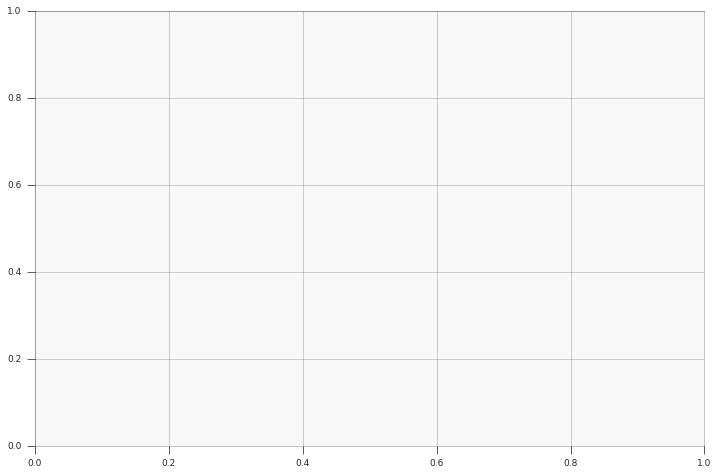

In [7]:
plt.figure(figsize=(12,8))
plt.scatter(np.arange(1000), np.array(ep_rewards1), label='Env 1')
plt.scatter(np.arange(1000), ep_rewards2, label='Env 2')
plt.show()

In [8]:
s1

[array([ 98,  99, 199], dtype=int16),
 array([ 96,  98, 198], dtype=int16),
 array([ 94,  97, 197], dtype=int16),
 array([ 93,  96, 196], dtype=int16),
 array([ 92,  95, 195], dtype=int16),
 array([ 91,  95, 194], dtype=int16),
 array([ 90,  95, 193], dtype=int16),
 array([ 89,  95, 192], dtype=int16),
 array([ 88,  95, 191], dtype=int16),
 array([ 87,  95, 190], dtype=int16),
 array([ 86,  95, 190], dtype=int16),
 array([ 85,  95, 190], dtype=int16),
 array([ 84,  95, 190], dtype=int16),
 array([ 83,  95, 190], dtype=int16),
 array([ 82,  95, 190], dtype=int16),
 array([ 81,  95, 190], dtype=int16),
 array([ 80,  95, 190], dtype=int16),
 array([ 79,  95, 190], dtype=int16),
 array([ 78,  95, 190], dtype=int16),
 array([ 77,  95, 190], dtype=int16),
 array([ 76,  95, 190], dtype=int16),
 array([ 75,  95, 190], dtype=int16),
 array([ 74,  95, 190], dtype=int16),
 array([ 73,  95, 190], dtype=int16),
 array([ 72,  95, 190], dtype=int16),
 array([ 71,  95, 190], dtype=int16),
 array([ 70,

In [9]:
np.allclose(np.vstack(s2)[:,:3], s1)

True

In [10]:
s2

[array([ 98.,  99., 199.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.]),
 array([ 96.,  98., 198.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 94.,  97., 197.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 93.,  96., 196.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.]),
 array([ 92.,  95., 195.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.

In [22]:
m = 3
lt_max = 10
for t in range(10):
    state = np.zeros(m*(lt_max+1))
    if t == 0:
        state[:m] = env2.I0
    else:
        state[:m] = env2.I[t]
    if t == 0:
        pass
    elif t >= lt_max:
        state[-m*lt_max] += env2.action_log[t-lt_max:t].flatten()
    else:
        state[-m*(t):] += env2.action_log[:t].flatten()
        
    print(t, state)

0 [100. 100. 200.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.]
1 [ 98.  99. 199.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   1.   1.   1.]
2 [ 96.  98. 198.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.
   1.   1.   1.   1.   1.]
3 [ 94.  97. 197.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.
   1.   1.   1.   1.   1.]
4 [ 93.  96. 196.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.]
5 [ 92.  95. 195.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.
 

In [11]:
x = np.vstack(s2)[:,3:]
x

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [0., 0., 0., 1., 1., 1., 1., 1., 1

In [37]:
sales = np.array([2, 1, 1, 1])
repl = np.array([1, 1, 1, 1])
unfulfilled = np.zeros(4)
inv1 = np.array([98, 99, 199])
inv2 = np.array([98, 99, 199, 0])

r1 = np.sum(env1.unit_price*sales) - np.sum(
    np.sum(env1.unit_cost*sales + env1.backlog_cost*unfulfilled)
            + np.sum(env1.holding_cost*inv1))
r2 = np.sum(env1.unit_price*sales) - np.sum(env1.unit_cost*sales + env1.backlog_cost*unfulfilled + 
        env2.holding_cost*inv2)
print(r1, r2)

-32.550000000000004 -32.550000000000004


# Find Tune Error

In [3]:
import ray
from ray import tune

In [4]:
env_name = "InvManagementMaster"
ray.init(ignore_reinit_error=True)
config = {"env": InvManagementMaster,
          "num_workers": 2}

# tune.register_env(env_name, lambda env_name: env(env_name))
results = tune.run(
    "A3C",
    checkpoint_freq=100,
    checkpoint_at_end=True,
    stop={"training_iteration": 500},
    config=config,
    reuse_actors=True)

2020-05-20 13:55:47,770	WARNING services.py:597 -- setpgrp failed, processes may not be cleaned up properly: [Errno 1] Operation not permitted.
2020-05-20 13:55:47,773	INFO resource_spec.py:216 -- Starting Ray with 3.96 GiB memory available for workers and up to 1.99 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-05-20 13:55:48,337	INFO ray_trial_executor.py:121 -- Trial A3C_InvManagementMaster_84a7e7c6: Setting up new remote runner.


Trial name,status,loc
A3C_InvManagementMaster_84a7e7c6,RUNNING,


(pid=26145) 2020-05-20 13:55:51,556	INFO trainer.py:371 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
(pid=26145) 2020-05-20 13:55:51,562	INFO trainer.py:512 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=26145) 2020-05-20 13:55:52,051	WARNING util.py:45 -- Install gputil for GPU system monitoring.
Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-55-57
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1057.55
  episode_reward_mean: -1171.968888888889
  episode_reward_min: -1302.1000000000001
  episodes_this_iter: 135
  episodes_total: 135
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.074
    dispatch_time_ms: 2.51
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 77.80093383789062
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,1,5.46886,4000,-1171.97


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-02
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -57.499999999999986
  episode_reward_mean: -1100.255263157895
  episode_reward_min: -1822.0
  episodes_this_iter: 266
  episodes_total: 401
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.116
    dispatch_time_ms: 3.611
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: 152.20098876953125
      policy_loss: -22974.59375
      var_gnorm: 24.010984420776367
      vf_explained_var: -3.4570693969726562e-06
      vf_loss: 151648.828125
    num_steps_sampled: 12000
    num_steps_trained: 12000
    wait_time_ms: 3.553
  iterations_since_restore: 2
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.9375
    ram_util_percent: 64.5625
  pid: 261

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,2,10.9066,12000,-1100.26


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-08
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 78.12500000000001
  episode_reward_mean: -504.90168539325845
  episode_reward_min: -1627.8499999999997
  episodes_this_iter: 267
  episodes_total: 668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.028
    dispatch_time_ms: 2.572
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 150.85995483398438
      policy_loss: -7193.97607421875
      var_gnorm: 28.138208389282227
      vf_explained_var: 1.7881393432617188e-06
      vf_loss: 19014.18359375
    num_steps_sampled: 20000
    num_steps_trained: 20000
    wait_time_ms: 3.881
  iterations_since_restore: 3
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.475
    ram_util_percent: 66.3125
  pid: 2

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,3,16.2229,20000,-504.902


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-13
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 358.19999999999993
  episode_reward_mean: -234.1578651685393
  episode_reward_min: -1274.175
  episodes_this_iter: 267
  episodes_total: 935
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.018
    dispatch_time_ms: 2.569
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999969482421875
      model: {}
      policy_entropy: 154.21957397460938
      policy_loss: 663.545166015625
      var_gnorm: 29.717403411865234
      vf_explained_var: -4.8160552978515625e-05
      vf_loss: 4152.72021484375
    num_steps_sampled: 28000
    num_steps_trained: 28000
    wait_time_ms: 4.319
  iterations_since_restore: 4
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.287499999999994
    ram_util_percent

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,4,21.7822,28000,-234.158


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-19
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 697.65
  episode_reward_mean: 88.37081545064376
  episode_reward_min: -831.3
  episodes_this_iter: 233
  episodes_total: 1168
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.925
    dispatch_time_ms: 2.358
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 172.33999633789062
      policy_loss: 8329.974609375
      var_gnorm: 29.528404235839844
      vf_explained_var: -8.344650268554688e-07
      vf_loss: 13566.234375
    num_steps_sampled: 35000
    num_steps_trained: 35000
    wait_time_ms: 3.02
  iterations_since_restore: 5
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.45714285714286
    ram_util_percent: 69.94285714285715
  pid: 26145
  pol

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,5,26.8934,35000,88.3708


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-24
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 812.5000000000001
  episode_reward_mean: 192.69201807228913
  episode_reward_min: -653.7249999999998
  episodes_this_iter: 166
  episodes_total: 1334
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.37
    dispatch_time_ms: 3.452
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 178.17153930664062
      policy_loss: 13725.6123046875
      var_gnorm: 29.39765739440918
      vf_explained_var: 1.1920928955078125e-07
      vf_loss: 37555.98046875
    num_steps_sampled: 40000
    num_steps_trained: 40000
    wait_time_ms: 5.583
  iterations_since_restore: 6
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.34285714285714
    ram_util_perce

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,6,32.0821,40000,192.692


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-29
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 626.725
  episode_reward_mean: 224.02412935323383
  episode_reward_min: -894.1750000000001
  episodes_this_iter: 201
  episodes_total: 1535
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.878
    dispatch_time_ms: 2.097
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 176.68177795410156
      policy_loss: 9348.97265625
      var_gnorm: 29.008705139160156
      vf_explained_var: -0.0001556873321533203
      vf_loss: 30509.5859375
    num_steps_sampled: 46000
    num_steps_trained: 46000
    wait_time_ms: 3.527
  iterations_since_restore: 7
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.5125
    ram_util_percent: 72.3625
  pid: 26145
  policy_r

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,7,37.2363,46000,224.024


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 698.3499999999999
  episode_reward_mean: 246.94055793991413
  episode_reward_min: -956.825
  episodes_this_iter: 233
  episodes_total: 1768
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.832
    dispatch_time_ms: 2.197
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 170.84097290039062
      policy_loss: 23224.052734375
      var_gnorm: 28.59762954711914
      vf_explained_var: -0.0004392862319946289
      vf_loss: 105944.0234375
    num_steps_sampled: 53000
    num_steps_trained: 53000
    wait_time_ms: 3.4
  iterations_since_restore: 8
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 56.25714285714286
    ram_util_percent: 73.89999

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,8,42.4341,53000,246.941


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-39
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 788.0999999999998
  episode_reward_mean: 232.31666666666663
  episode_reward_min: -1056.4
  episodes_this_iter: 234
  episodes_total: 2002
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.999
    dispatch_time_ms: 2.34
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000003814697266
      model: {}
      policy_entropy: 169.08383178710938
      policy_loss: 11115.6669921875
      var_gnorm: 28.4410400390625
      vf_explained_var: -0.0011175870895385742
      vf_loss: 34423.19140625
    num_steps_sampled: 60000
    num_steps_trained: 60000
    wait_time_ms: 3.807
  iterations_since_restore: 9
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.175
    ram_util_percent: 75.4875
  pid: 261

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,9,47.6932,60000,232.317


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 681.5999999999999
  episode_reward_mean: 115.63286516853933
  episode_reward_min: -1018.3499999999999
  episodes_this_iter: 267
  episodes_total: 2269
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.875
    dispatch_time_ms: 2.204
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: 156.1864471435547
      policy_loss: -6179.142578125
      var_gnorm: 28.49795913696289
      vf_explained_var: -2.384185791015625e-07
      vf_loss: 8382.97265625
    num_steps_sampled: 68000
    num_steps_trained: 68000
    wait_time_ms: 3.39
  iterations_since_restore: 10
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.974999999999994
    ram_util_percen

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,10,53.3801,68000,115.633


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 556.9499999999998
  episode_reward_mean: 145.9577889447236
  episode_reward_min: -692.1499999999999
  episodes_this_iter: 199
  episodes_total: 2468
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.469
    dispatch_time_ms: 3.087
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: 143.79844665527344
      policy_loss: 13566.1025390625
      var_gnorm: 28.633342742919922
      vf_explained_var: 2.384185791015625e-07
      vf_loss: 53301.08984375
    num_steps_sampled: 74000
    num_steps_trained: 74000
    wait_time_ms: 5.019
  iterations_since_restore: 11
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.81428571428571
    ram_util_perc

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,11,58.6244,74000,145.958


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-56-56
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 589.375
  episode_reward_mean: 321.69174999999996
  episode_reward_min: -256.65000000000003
  episodes_this_iter: 200
  episodes_total: 2668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.17
    dispatch_time_ms: 2.729
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 136.08074951171875
      policy_loss: 13020.80859375
      var_gnorm: 29.05579376220703
      vf_explained_var: 0.0
      vf_loss: 57447.6171875
    num_steps_sampled: 80000
    num_steps_trained: 80000
    wait_time_ms: 4.382
  iterations_since_restore: 12
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.8125
    ram_util_percent: 79.88749999999999
  pid: 26145
  policy_reward_ma

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,12,64.3268,80000,321.692


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 640.1000000000001
  episode_reward_mean: 427.49524999999994
  episode_reward_min: 100.9499999999999
  episodes_this_iter: 200
  episodes_total: 2868
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.027
    dispatch_time_ms: 2.623
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: 104.08399963378906
      policy_loss: -982.93505859375
      var_gnorm: 29.22534942626953
      vf_explained_var: 5.960464477539063e-08
      vf_loss: 4129.0224609375
    num_steps_sampled: 86000
    num_steps_trained: 86000
    wait_time_ms: 4.171
  iterations_since_restore: 13
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.2875
    ram_util_percent: 80.12

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,13,69.5578,86000,427.495


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-07
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 646.675
  episode_reward_mean: 450.83728632478625
  episode_reward_min: 254.27499999999995
  episodes_this_iter: 234
  episodes_total: 3102
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.033
    dispatch_time_ms: 2.626
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00003433227539
      model: {}
      policy_entropy: 96.85324096679688
      policy_loss: 5842.93896484375
      var_gnorm: 29.925540924072266
      vf_explained_var: -1.1920928955078125e-07
      vf_loss: 23377.990234375
    num_steps_sampled: 93000
    num_steps_trained: 93000
    wait_time_ms: 2.195
  iterations_since_restore: 14
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.412499999999994
    ram_util_percent: 8

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,14,74.9739,93000,450.837


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-12
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 587.3000000000002
  episode_reward_mean: 390.89626068376066
  episode_reward_min: 169.57499999999985
  episodes_this_iter: 234
  episodes_total: 3336
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.044
    dispatch_time_ms: 3.31
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.9999885559082
      model: {}
      policy_entropy: 82.31748962402344
      policy_loss: 11905.5908203125
      var_gnorm: 29.78485870361328
      vf_explained_var: -5.614757537841797e-05
      vf_loss: 126952.65625
    num_steps_sampled: 100000
    num_steps_trained: 100000
    wait_time_ms: 3.808
  iterations_since_restore: 15
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.32857142857143
    ram_util_percen

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,15,80.2798,100000,390.896


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-17
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 556.65
  episode_reward_mean: 375.5219827586207
  episode_reward_min: 177.55
  episodes_this_iter: 232
  episodes_total: 3568
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.056
    dispatch_time_ms: 2.351
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99995422363281
      model: {}
      policy_entropy: 82.02651977539062
      policy_loss: 8860.841796875
      var_gnorm: 29.900001525878906
      vf_explained_var: 0.0
      vf_loss: 66293.03125
    num_steps_sampled: 107000
    num_steps_trained: 107000
    wait_time_ms: 4.294
  iterations_since_restore: 16
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.8875
    ram_util_percent: 80.4
  pid: 26145
  policy_reward_max: {}
  policy

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,16,85.4863,107000,375.522


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-23
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 669.225
  episode_reward_mean: 415.1460300429185
  episode_reward_min: 183.5250000000001
  episodes_this_iter: 233
  episodes_total: 3801
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.173
    dispatch_time_ms: 2.629
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.9999885559082
      model: {}
      policy_entropy: 73.37923431396484
      policy_loss: 7114.1025390625
      var_gnorm: 29.785154342651367
      vf_explained_var: -2.1457672119140625e-06
      vf_loss: 67517.078125
    num_steps_sampled: 114000
    num_steps_trained: 114000
    wait_time_ms: 4.259
  iterations_since_restore: 17
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.325
    ram_util_percent: 80.41250000000001


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,17,91.0977,114000,415.146


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 667.175
  episode_reward_mean: 483.29294871794866
  episode_reward_min: 169.7
  episodes_this_iter: 234
  episodes_total: 4035
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.941
    dispatch_time_ms: 2.254
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999996185302734
      model: {}
      policy_entropy: 71.36687469482422
      policy_loss: -3156.8505859375
      var_gnorm: 30.55272674560547
      vf_explained_var: 0.0
      vf_loss: 12034.126953125
    num_steps_sampled: 121000
    num_steps_trained: 121000
    wait_time_ms: 4.077
  iterations_since_restore: 18
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 54.099999999999994
    ram_util_percent: 80.4875
  pid: 26145
  policy_re

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,18,96.74,121000,483.293


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 684.9
  episode_reward_mean: 493.05321888412016
  episode_reward_min: 198.69999999999996
  episodes_this_iter: 233
  episodes_total: 4268
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.106
    dispatch_time_ms: 2.61
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00006103515625
      model: {}
      policy_entropy: 70.15404510498047
      policy_loss: 7006.609375
      var_gnorm: 30.609230041503906
      vf_explained_var: 0.0
      vf_loss: 48880.515625
    num_steps_sampled: 128000
    num_steps_trained: 128000
    wait_time_ms: 4.211
  iterations_since_restore: 19
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.12857142857143
    ram_util_percent: 80.60000000000001
  pid: 26145


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,19,102.096,128000,493.053


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-39
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 645.6999999999999
  episode_reward_mean: 462.6914893617021
  episode_reward_min: 270.80000000000007
  episodes_this_iter: 235
  episodes_total: 4503
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.142
    dispatch_time_ms: 8.115
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00001525878906
      model: {}
      policy_entropy: 59.72271728515625
      policy_loss: 3427.686767578125
      var_gnorm: 30.963603973388672
      vf_explained_var: -1.1920928955078125e-07
      vf_loss: 20905.08984375
    num_steps_sampled: 135000
    num_steps_trained: 135000
    wait_time_ms: 2.915
  iterations_since_restore: 20
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.5
    ram_util_percent: 80.7

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,20,107.453,135000,462.691


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 640.6749999999998
  episode_reward_mean: 418.1030172413793
  episode_reward_min: 197.60000000000002
  episodes_this_iter: 232
  episodes_total: 4735
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.005
    dispatch_time_ms: 2.411
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000022888183594
      model: {}
      policy_entropy: 80.10570526123047
      policy_loss: 7742.39208984375
      var_gnorm: 30.960695266723633
      vf_explained_var: 0.0
      vf_loss: 60874.52734375
    num_steps_sampled: 142000
    num_steps_trained: 142000
    wait_time_ms: 4.306
  iterations_since_restore: 21
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.45
    ram_util_percent: 80.6875
  pid: 26145
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,21,112.855,142000,418.103


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 611.075
  episode_reward_mean: 403.01899141630895
  episode_reward_min: 164.55
  episodes_this_iter: 233
  episodes_total: 4968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.977
    dispatch_time_ms: 2.724
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00003433227539
      model: {}
      policy_entropy: 64.6864013671875
      policy_loss: 5008.9736328125
      var_gnorm: 30.566476821899414
      vf_explained_var: -2.384185791015625e-07
      vf_loss: 40233.9921875
    num_steps_sampled: 149000
    num_steps_trained: 149000
    wait_time_ms: 4.554
  iterations_since_restore: 22
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.4375
    ram_util_percent: 80.67500000000001
  pid: 26

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,22,118.405,149000,403.019


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-57-55
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 540.65
  episode_reward_mean: 372.49542553191486
  episode_reward_min: 141.35000000000002
  episodes_this_iter: 235
  episodes_total: 5203
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.068
    dispatch_time_ms: 2.504
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 75.23826599121094
      policy_loss: -7158.2626953125
      var_gnorm: 29.971662521362305
      vf_explained_var: 0.0
      vf_loss: 49667.9453125
    num_steps_sampled: 156000
    num_steps_trained: 156000
    wait_time_ms: 7.547
  iterations_since_restore: 23
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.72857142857142
    ram_util_percent: 80.7
  pid: 26145
  pol

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,23,123.61,156000,372.495


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 565.2249999999998
  episode_reward_mean: 375.3361587982832
  episode_reward_min: 123.42499999999995
  episodes_this_iter: 233
  episodes_total: 5436
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.046
    dispatch_time_ms: 6.931
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000030517578125
      model: {}
      policy_entropy: 73.6116714477539
      policy_loss: 1928.2490234375
      var_gnorm: 30.300334930419922
      vf_explained_var: -1.1920928955078125e-07
      vf_loss: 9178.505859375
    num_steps_sampled: 163000
    num_steps_trained: 163000
    wait_time_ms: 2.014
  iterations_since_restore: 24
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.3125
    ram_util_percent: 80.

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,24,128.964,163000,375.336


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-06
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 556.2
  episode_reward_mean: 376.49051724137934
  episode_reward_min: 157.07500000000005
  episodes_this_iter: 232
  episodes_total: 5668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.892
    dispatch_time_ms: 2.116
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: 54.680938720703125
      policy_loss: 3269.0166015625
      var_gnorm: 30.779895782470703
      vf_explained_var: -1.1920928955078125e-07
      vf_loss: 38086.2578125
    num_steps_sampled: 170000
    num_steps_trained: 170000
    wait_time_ms: 3.964
  iterations_since_restore: 25
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.77142857142858
    ram_util_percent: 80.7

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,25,134.061,170000,376.491


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-11
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 508.57500000000005
  episode_reward_mean: 343.80715811965814
  episode_reward_min: 92.82500000000003
  episodes_this_iter: 234
  episodes_total: 5902
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.065
    dispatch_time_ms: 2.699
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999977111816406
      model: {}
      policy_entropy: 57.292030334472656
      policy_loss: -10594.3984375
      var_gnorm: 30.510751724243164
      vf_explained_var: 0.0
      vf_loss: 136454.34375
    num_steps_sampled: 177000
    num_steps_trained: 177000
    wait_time_ms: 2.39
  iterations_since_restore: 26
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.0125
    ram_util_percent: 80.7
  pid: 26145
  poli

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,26,139.383,177000,343.807


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-17
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 512.4000000000001
  episode_reward_mean: 331.4440425531915
  episode_reward_min: 85.17499999999994
  episodes_this_iter: 235
  episodes_total: 6137
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.963
    dispatch_time_ms: 2.418
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: 61.43789291381836
      policy_loss: 6361.44140625
      var_gnorm: 30.640605926513672
      vf_explained_var: -1.1920928955078125e-07
      vf_loss: 56670.30078125
    num_steps_sampled: 184000
    num_steps_trained: 184000
    wait_time_ms: 2.378
  iterations_since_restore: 27
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.137499999999996
    ram_util_perce

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,27,145.08,184000,331.444


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-23
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 512.275
  episode_reward_mean: 321.40398706896553
  episode_reward_min: 131.05000000000007
  episodes_this_iter: 232
  episodes_total: 6369
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.043
    dispatch_time_ms: 2.655
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999977111816406
      model: {}
      policy_entropy: 51.10384750366211
      policy_loss: -2422.258056640625
      var_gnorm: 30.29817771911621
      vf_explained_var: -0.00025260448455810547
      vf_loss: 14569.130859375
    num_steps_sampled: 191000
    num_steps_trained: 191000
    wait_time_ms: 2.357
  iterations_since_restore: 28
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.125
    ram_util_percent: 80.7625
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,28,150.833,191000,321.404


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 505.5
  episode_reward_mean: 321.14337606837614
  episode_reward_min: 89.2249999999999
  episodes_this_iter: 234
  episodes_total: 6603
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.109
    dispatch_time_ms: 2.906
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999977111816406
      model: {}
      policy_entropy: 43.09934997558594
      policy_loss: 4592.45458984375
      var_gnorm: 30.076061248779297
      vf_explained_var: -9.608268737792969e-05
      vf_loss: 56731.80859375
    num_steps_sampled: 198000
    num_steps_trained: 198000
    wait_time_ms: 2.868
  iterations_since_restore: 29
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.1625
    ram_util_percent: 80.7875
  pid: 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,29,156.536,198000,321.143


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 510.0249999999999
  episode_reward_mean: 331.3693376068376
  episode_reward_min: 126.82499999999995
  episodes_this_iter: 234
  episodes_total: 6837
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.14
    dispatch_time_ms: 8.037
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99995803833008
      model: {}
      policy_entropy: 43.818504333496094
      policy_loss: 2661.015869140625
      var_gnorm: 30.10451889038086
      vf_explained_var: -5.0067901611328125e-06
      vf_loss: 12587.8056640625
    num_steps_sampled: 205000
    num_steps_trained: 205000
    wait_time_ms: 2.054
  iterations_since_restore: 30
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.1
    ram_util_percent: 80.

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,30,162.136,205000,331.369


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-40
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 528.7250000000001
  episode_reward_mean: 319.5109307359307
  episode_reward_min: 62.175000000000054
  episodes_this_iter: 231
  episodes_total: 7068
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.279
    dispatch_time_ms: 2.803
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00001525878906
      model: {}
      policy_entropy: 31.942405700683594
      policy_loss: -3045.900146484375
      var_gnorm: 30.13189125061035
      vf_explained_var: 0.0
      vf_loss: 39996.796875
    num_steps_sampled: 212000
    num_steps_trained: 212000
    wait_time_ms: 4.248
  iterations_since_restore: 31
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.275000000000006
    ram_util_percent: 80.8
  pid:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,31,167.809,212000,319.511


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 543.5
  episode_reward_mean: 363.1069444444444
  episode_reward_min: 29.59999999999995
  episodes_this_iter: 234
  episodes_total: 7302
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.142
    dispatch_time_ms: 3.025
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999961853027344
      model: {}
      policy_entropy: 30.012981414794922
      policy_loss: -2215.73193359375
      var_gnorm: 29.6555118560791
      vf_explained_var: 5.960464477539063e-08
      vf_loss: 35946.703125
    num_steps_sampled: 219000
    num_steps_trained: 219000
    wait_time_ms: 6.011
  iterations_since_restore: 32
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.5625
    ram_util_percent: 80.8
  pid: 26145


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,32,173.34,219000,363.107


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-51
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 524.05
  episode_reward_mean: 354.79302575107295
  episode_reward_min: 68.19999999999997
  episodes_this_iter: 233
  episodes_total: 7535
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.171
    dispatch_time_ms: 2.684
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999996185302734
      model: {}
      policy_entropy: 35.47406768798828
      policy_loss: 2678.44775390625
      var_gnorm: 29.545076370239258
      vf_explained_var: 2.384185791015625e-07
      vf_loss: 42153.125
    num_steps_sampled: 226000
    num_steps_trained: 226000
    wait_time_ms: 4.708
  iterations_since_restore: 33
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 54.1125
    ram_util_percent: 80.6625
  pid: 2614

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,33,178.962,226000,354.793


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-58-56
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 527.3000000000001
  episode_reward_mean: 363.69425
  episode_reward_min: 64.875
  episodes_this_iter: 200
  episodes_total: 7735
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.142
    dispatch_time_ms: 3.373
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00000762939453
      model: {}
      policy_entropy: 35.23940658569336
      policy_loss: 3542.579345703125
      var_gnorm: 29.564733505249023
      vf_explained_var: 5.960464477539063e-08
      vf_loss: 73806.5859375
    num_steps_sampled: 232000
    num_steps_trained: 232000
    wait_time_ms: 4.045
  iterations_since_restore: 34
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.45
    ram_util_percent: 80.5125
  pid: 26145
  pol

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,34,184.277,232000,363.694


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-02
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 555.5999999999999
  episode_reward_mean: 354.7796137339056
  episode_reward_min: 127.80000000000004
  episodes_this_iter: 233
  episodes_total: 7968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.019
    dispatch_time_ms: 2.635
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00006103515625
      model: {}
      policy_entropy: 38.727264404296875
      policy_loss: 5130.2138671875
      var_gnorm: 29.402198791503906
      vf_explained_var: 3.5762786865234375e-07
      vf_loss: 68253.3203125
    num_steps_sampled: 239000
    num_steps_trained: 239000
    wait_time_ms: 4.409
  iterations_since_restore: 35
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.9125
    ram_util_percent: 80.5

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,35,189.918,239000,354.78


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-07
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 515.9
  episode_reward_mean: 362.18269230769226
  episode_reward_min: 112.80000000000001
  episodes_this_iter: 234
  episodes_total: 8202
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.173
    dispatch_time_ms: 2.524
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 30.097421646118164
      policy_loss: -1476.62890625
      var_gnorm: 29.383588790893555
      vf_explained_var: 1.1920928955078125e-07
      vf_loss: 18254.1484375
    num_steps_sampled: 246000
    num_steps_trained: 246000
    wait_time_ms: 4.455
  iterations_since_restore: 36
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.885714285714286
    ram_util_percent: 80.58571428571429


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,36,195.275,246000,362.183


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-13
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 565.0500000000001
  episode_reward_mean: 366.03793103448277
  episode_reward_min: 106.00000000000009
  episodes_this_iter: 232
  episodes_total: 8434
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.072
    dispatch_time_ms: 2.317
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998092651367
      model: {}
      policy_entropy: 36.414955139160156
      policy_loss: 3261.96630859375
      var_gnorm: 29.596649169921875
      vf_explained_var: -0.00031638145446777344
      vf_loss: 60827.015625
    num_steps_sampled: 253000
    num_steps_trained: 253000
    wait_time_ms: 1.941
  iterations_since_restore: 37
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.55
    ram_util_percent: 80.6

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,37,200.648,253000,366.038


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-18
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 584.7250000000001
  episode_reward_mean: 364.44433760683756
  episode_reward_min: 29.24999999999993
  episodes_this_iter: 234
  episodes_total: 8668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.202
    dispatch_time_ms: 2.492
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00001525878906
      model: {}
      policy_entropy: 27.450416564941406
      policy_loss: 274.86065673828125
      var_gnorm: 29.408113479614258
      vf_explained_var: -1.9073486328125e-06
      vf_loss: 3587.5146484375
    num_steps_sampled: 260000
    num_steps_trained: 260000
    wait_time_ms: 3.892
  iterations_since_restore: 38
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.857142857142854
    ram_util

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,38,205.889,260000,364.444


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-23
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 540.1
  episode_reward_mean: 356.05737500000004
  episode_reward_min: 48.30000000000011
  episodes_this_iter: 200
  episodes_total: 8868
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.122
    dispatch_time_ms: 2.707
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 19.268444061279297
      policy_loss: 2429.7958984375
      var_gnorm: 29.47808074951172
      vf_explained_var: 4.76837158203125e-07
      vf_loss: 79519.6015625
    num_steps_sampled: 266000
    num_steps_trained: 266000
    wait_time_ms: 4.603
  iterations_since_restore: 39
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.275
    ram_util_percent: 80.6
  pid: 26145
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,39,211.038,266000,356.057


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-29
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 573.4499999999999
  episode_reward_mean: 360.2279914529914
  episode_reward_min: 140.0
  episodes_this_iter: 234
  episodes_total: 9102
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.139
    dispatch_time_ms: 2.597
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: 28.80430030822754
      policy_loss: -2178.2763671875
      var_gnorm: 29.22732925415039
      vf_explained_var: 1.7285346984863281e-06
      vf_loss: 45449.6875
    num_steps_sampled: 273000
    num_steps_trained: 273000
    wait_time_ms: 4.147
  iterations_since_restore: 40
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.675
    ram_util_percent: 80.65
  pid: 26145
  po

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,40,216.76,273000,360.228


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 577.1000000000001
  episode_reward_mean: 354.40075431034484
  episode_reward_min: 20.849999999999994
  episodes_this_iter: 232
  episodes_total: 9334
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.044
    dispatch_time_ms: 2.494
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00001525878906
      model: {}
      policy_entropy: 43.89006042480469
      policy_loss: 3583.9873046875
      var_gnorm: 29.667760848999023
      vf_explained_var: 1.1920928955078125e-07
      vf_loss: 60440.3984375
    num_steps_sampled: 280000
    num_steps_trained: 280000
    wait_time_ms: 3.683
  iterations_since_restore: 41
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.05714285714286
    ram_util_per

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,41,222.053,280000,354.401


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-40
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 565.1
  episode_reward_mean: 366.07179487179485
  episode_reward_min: 130.64999999999992
  episodes_this_iter: 234
  episodes_total: 9568
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.932
    dispatch_time_ms: 2.249
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 35.438175201416016
      policy_loss: 5286.43994140625
      var_gnorm: 29.751731872558594
      vf_explained_var: 4.76837158203125e-07
      vf_loss: 78902.0703125
    num_steps_sampled: 287000
    num_steps_trained: 287000
    wait_time_ms: 2.155
  iterations_since_restore: 42
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.5625
    ram_util_percent: 80.7
  pid: 26145
  policy_re

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,42,227.56,287000,366.072


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 513.8750000000001
  episode_reward_mean: 349.93154506437764
  episode_reward_min: 6.649999999999892
  episodes_this_iter: 233
  episodes_total: 9801
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.051
    dispatch_time_ms: 2.355
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: 27.40545082092285
      policy_loss: 1429.61083984375
      var_gnorm: 29.547176361083984
      vf_explained_var: -8.71419906616211e-05
      vf_loss: 22048.220703125
    num_steps_sampled: 294000
    num_steps_trained: 294000
    wait_time_ms: 4.611
  iterations_since_restore: 43
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.9625
    ram_util_percent: 80.

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,43,232.753,294000,349.932


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 554.0749999999999
  episode_reward_mean: 353.28258706467665
  episode_reward_min: 107.24999999999991
  episodes_this_iter: 201
  episodes_total: 10002
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.425
    dispatch_time_ms: 3.284
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998092651367
      model: {}
      policy_entropy: 10.072846412658691
      policy_loss: -905.3629150390625
      var_gnorm: 29.67234230041504
      vf_explained_var: 1.0132789611816406e-06
      vf_loss: 64029.25
    num_steps_sampled: 300000
    num_steps_trained: 300000
    wait_time_ms: 4.865
  iterations_since_restore: 44
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.471428571428575
    ram_util_per

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,44,237.838,300000,353.283


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_13-59-55
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 611.3250000000002
  episode_reward_mean: 377.28287499999993
  episode_reward_min: 114.27499999999999
  episodes_this_iter: 200
  episodes_total: 10202
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.122
    dispatch_time_ms: 2.413
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 14.435741424560547
      policy_loss: -857.741943359375
      var_gnorm: 29.673744201660156
      vf_explained_var: 5.960464477539062e-07
      vf_loss: 71914.984375
    num_steps_sampled: 306000
    num_steps_trained: 306000
    wait_time_ms: 4.003
  iterations_since_restore: 45
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.199999999999996
    ram_util_

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,45,242.861,306000,377.283


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-00
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 604.825
  episode_reward_mean: 396.38234042553194
  episode_reward_min: 147.52500000000006
  episodes_this_iter: 235
  episodes_total: 10437
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.042
    dispatch_time_ms: 3.096
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00000762939453
      model: {}
      policy_entropy: 19.46150016784668
      policy_loss: -2429.12939453125
      var_gnorm: 30.373544692993164
      vf_explained_var: 0.0
      vf_loss: 93143.875
    num_steps_sampled: 313000
    num_steps_trained: 313000
    wait_time_ms: 6.984
  iterations_since_restore: 46
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.0125
    ram_util_percent: 80.7
  pid: 26145
  policy_reward_

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,46,248.253,313000,396.382


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-05
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 583.725
  episode_reward_mean: 383.5941558441558
  episode_reward_min: 37.07500000000003
  episodes_this_iter: 231
  episodes_total: 10668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.088
    dispatch_time_ms: 2.67
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99997329711914
      model: {}
      policy_entropy: 12.714363098144531
      policy_loss: 1479.3731689453125
      var_gnorm: 30.42618751525879
      vf_explained_var: 2.980232238769531e-07
      vf_loss: 51303.9765625
    num_steps_sampled: 320000
    num_steps_trained: 320000
    wait_time_ms: 4.088
  iterations_since_restore: 47
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.22857142857142
    ram_util_percent: 80.7

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,47,253.366,320000,383.594


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-11
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 624.9749999999999
  episode_reward_mean: 377.84155982905986
  episode_reward_min: 103.4499999999999
  episodes_this_iter: 234
  episodes_total: 10902
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.955
    dispatch_time_ms: 2.589
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: 26.98948860168457
      policy_loss: 3466.98291015625
      var_gnorm: 30.3930606842041
      vf_explained_var: 5.960464477539063e-08
      vf_loss: 93805.5625
    num_steps_sampled: 327000
    num_steps_trained: 327000
    wait_time_ms: 3.976
  iterations_since_restore: 48
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.025
    ram_util_percent: 80.7875
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,48,258.615,327000,377.842


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-16
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 611.8000000000001
  episode_reward_mean: 380.88143776824035
  episode_reward_min: 114.92499999999998
  episodes_this_iter: 233
  episodes_total: 11135
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.034
    dispatch_time_ms: 2.562
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999969482421875
      model: {}
      policy_entropy: 32.01167678833008
      policy_loss: -3093.42822265625
      var_gnorm: 30.374549865722656
      vf_explained_var: 0.0
      vf_loss: 50288.09375
    num_steps_sampled: 334000
    num_steps_trained: 334000
    wait_time_ms: 2.848
  iterations_since_restore: 49
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.425
    ram_util_percent: 80.8625
  pid: 26145
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,49,264.335,334000,380.881


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-22
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 590.4750000000001
  episode_reward_mean: 365.2564893617021
  episode_reward_min: 75.70000000000003
  episodes_this_iter: 235
  episodes_total: 11370
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.995
    dispatch_time_ms: 2.531
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000022888183594
      model: {}
      policy_entropy: 19.67892074584961
      policy_loss: 402.54345703125
      var_gnorm: 30.5233097076416
      vf_explained_var: -1.621246337890625e-05
      vf_loss: 4820.017578125
    num_steps_sampled: 341000
    num_steps_trained: 341000
    wait_time_ms: 2.394
  iterations_since_restore: 50
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.587500000000006
    ram_util_per

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,50,270.053,341000,365.256


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 554.1000000000001
  episode_reward_mean: 363.9671717171717
  episode_reward_min: 7.624999999999957
  episodes_this_iter: 198
  episodes_total: 11568
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.216
    dispatch_time_ms: 2.688
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00002670288086
      model: {}
      policy_entropy: 26.7791748046875
      policy_loss: 3351.85888671875
      var_gnorm: 30.702451705932617
      vf_explained_var: 2.980232238769531e-07
      vf_loss: 58701.20703125
    num_steps_sampled: 347000
    num_steps_trained: 347000
    wait_time_ms: 5.167
  iterations_since_restore: 51
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.1
    ram_util_percent: 80.9
  p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,51,275.66,347000,363.967


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-33
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 604.1249999999999
  episode_reward_mean: 367.386875
  episode_reward_min: 145.75000000000014
  episodes_this_iter: 200
  episodes_total: 11768
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.978
    dispatch_time_ms: 3.372
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 29.51324462890625
      policy_loss: 5192.6015625
      var_gnorm: 30.839765548706055
      vf_explained_var: 1.1920928955078125e-07
      vf_loss: 83108.953125
    num_steps_sampled: 353000
    num_steps_trained: 353000
    wait_time_ms: 4.613
  iterations_since_restore: 52
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.71428571428572
    ram_util_percent: 80.89999999999999


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,52,280.841,353000,367.387


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-39
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 604.3249999999998
  episode_reward_mean: 386.9827253218884
  episode_reward_min: 138.4249999999999
  episodes_this_iter: 233
  episodes_total: 12001
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.183
    dispatch_time_ms: 2.669
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.9999885559082
      model: {}
      policy_entropy: 34.27623748779297
      policy_loss: 1343.57568359375
      var_gnorm: 30.11191749572754
      vf_explained_var: 1.1920928955078125e-07
      vf_loss: 14880.923828125
    num_steps_sampled: 360000
    num_steps_trained: 360000
    wait_time_ms: 4.019
  iterations_since_restore: 53
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.1625
    ram_util_percent: 80.9

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,53,286.387,360000,386.983


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-44
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 584.4499999999999
  episode_reward_mean: 352.85427350427346
  episode_reward_min: 35.92499999999992
  episodes_this_iter: 234
  episodes_total: 12235
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.107
    dispatch_time_ms: 2.565
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000022888183594
      model: {}
      policy_entropy: 38.259803771972656
      policy_loss: 4853.52197265625
      var_gnorm: 30.609224319458008
      vf_explained_var: -3.790855407714844e-05
      vf_loss: 72259.1640625
    num_steps_sampled: 367000
    num_steps_trained: 367000
    wait_time_ms: 4.703
  iterations_since_restore: 54
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.400000000000006
    ram_util

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,54,292.103,367000,352.854


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 584.5749999999999
  episode_reward_mean: 364.39248927038625
  episode_reward_min: 30.774999999999935
  episodes_this_iter: 233
  episodes_total: 12468
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.968
    dispatch_time_ms: 2.641
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: 26.58371353149414
      policy_loss: 2651.933837890625
      var_gnorm: 30.491037368774414
      vf_explained_var: -7.152557373046875e-07
      vf_loss: 74237.6953125
    num_steps_sampled: 374000
    num_steps_trained: 374000
    wait_time_ms: 4.231
  iterations_since_restore: 55
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.24444444444444
    ram_util_percent: 80.9

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,55,297.761,374000,364.392


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-00-56
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 569.575
  episode_reward_mean: 355.81217948717944
  episode_reward_min: 143.89999999999998
  episodes_this_iter: 234
  episodes_total: 12702
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.069
    dispatch_time_ms: 2.503
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99997329711914
      model: {}
      policy_entropy: 14.79220962524414
      policy_loss: 510.89501953125
      var_gnorm: 30.442283630371094
      vf_explained_var: -4.506111145019531e-05
      vf_loss: 19268.94921875
    num_steps_sampled: 381000
    num_steps_trained: 381000
    wait_time_ms: 4.934
  iterations_since_restore: 56
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.6375
    ram_util_percent: 80.95
  pid:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,56,303.382,381000,355.812


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 534.7
  episode_reward_mean: 293.2618025751073
  episode_reward_min: 54.27499999999992
  episodes_this_iter: 233
  episodes_total: 12935
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.208
    dispatch_time_ms: 2.484
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: 0.2500882148742676
      policy_loss: 71.28577423095703
      var_gnorm: 30.504344940185547
      vf_explained_var: 0.03025442361831665
      vf_loss: 2560.69970703125
    num_steps_sampled: 388000
    num_steps_trained: 388000
    wait_time_ms: 3.522
  iterations_since_restore: 57
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.875
    ram_util_percent: 80.9875
  pid: 2

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,57,309.098,388000,293.262


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-07
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 441.6999999999999
  episode_reward_mean: 274.50375536480686
  episode_reward_min: 87.39999999999992
  episodes_this_iter: 233
  episodes_total: 13168
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.118
    dispatch_time_ms: 2.359
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: -1.9779601097106934
      policy_loss: 403.39892578125
      var_gnorm: 30.545379638671875
      vf_explained_var: -0.0003973245620727539
      vf_loss: 344981.9375
    num_steps_sampled: 395000
    num_steps_trained: 395000
    wait_time_ms: 4.107
  iterations_since_restore: 58
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.942857142857136
    ram_util_pe

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,58,314.403,395000,274.504


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-12
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 359.52499999999986
  episode_reward_mean: 239.71373390557937
  episode_reward_min: 64.37499999999989
  episodes_this_iter: 233
  episodes_total: 13401
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.068
    dispatch_time_ms: 2.353
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: -10.70341682434082
      policy_loss: -271.49139404296875
      var_gnorm: 30.57849884033203
      vf_explained_var: 0.028118491172790527
      vf_loss: 13071.4951171875
    num_steps_sampled: 402000
    num_steps_trained: 402000
    wait_time_ms: 3.733
  iterations_since_restore: 59
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.725
    ram_util_percent: 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,59,319.845,402000,239.714


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-18
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 340.225
  episode_reward_mean: 237.98290598290595
  episode_reward_min: 20.624999999999858
  episodes_this_iter: 234
  episodes_total: 13635
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.093
    dispatch_time_ms: 2.735
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: -5.003228664398193
      policy_loss: 178.16465759277344
      var_gnorm: 30.615848541259766
      vf_explained_var: 0.036487460136413574
      vf_loss: 6592.74462890625
    num_steps_sampled: 409000
    num_steps_trained: 409000
    wait_time_ms: 3.199
  iterations_since_restore: 60
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.75
    ram_util_percent: 81.1
  pid

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,60,325.291,409000,237.983


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-23
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 324.67499999999995
  episode_reward_mean: 245.12899999999993
  episode_reward_min: 96.97499999999988
  episodes_this_iter: 200
  episodes_total: 13835
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.569
    dispatch_time_ms: 3.11
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000003814697266
      model: {}
      policy_entropy: -5.428832530975342
      policy_loss: 311.1315002441406
      var_gnorm: 30.664493560791016
      vf_explained_var: 0.00023114681243896484
      vf_loss: 153426.1875
    num_steps_sampled: 415000
    num_steps_trained: 415000
    wait_time_ms: 4.052
  iterations_since_restore: 61
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 54.042857142857144
    ram_util_

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,61,330.542,415000,245.129


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 418.5250000000001
  episode_reward_mean: 260.2564102564103
  episode_reward_min: 65.72500000000004
  episodes_this_iter: 234
  episodes_total: 14069
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.991
    dispatch_time_ms: 2.723
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000003814697266
      model: {}
      policy_entropy: 16.923603057861328
      policy_loss: -4602.5966796875
      var_gnorm: 30.734975814819336
      vf_explained_var: -0.0013644695281982422
      vf_loss: 261770.453125
    num_steps_sampled: 422000
    num_steps_trained: 422000
    wait_time_ms: 4.324
  iterations_since_restore: 62
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.5
    ram_util_percent: 81.0


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,62,336.206,422000,260.256


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 456.7499999999998
  episode_reward_mean: 249.2809012875536
  episode_reward_min: 6.92500000000004
  episodes_this_iter: 233
  episodes_total: 14302
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.042
    dispatch_time_ms: 2.631
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.999996185302734
      model: {}
      policy_entropy: 3.022757053375244
      policy_loss: 208.1676788330078
      var_gnorm: 30.803604125976562
      vf_explained_var: -0.00010573863983154297
      vf_loss: 114275.25
    num_steps_sampled: 429000
    num_steps_trained: 429000
    wait_time_ms: 2.371
  iterations_since_restore: 63
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.2625
    ram_util_percent: 81.012

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,63,341.778,429000,249.281


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-40
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 333.47499999999997
  episode_reward_mean: 187.83154506437768
  episode_reward_min: 65.89999999999998
  episodes_this_iter: 233
  episodes_total: 14535
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.275
    dispatch_time_ms: 2.549
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99998474121094
      model: {}
      policy_entropy: -12.080907821655273
      policy_loss: 4195.15966796875
      var_gnorm: 30.85674285888672
      vf_explained_var: 5.364418029785156e-06
      vf_loss: 465937.5
    num_steps_sampled: 436000
    num_steps_trained: 436000
    wait_time_ms: 4.976
  iterations_since_restore: 64
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.2375
    ram_util_percent: 81.0874

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,64,347.31,436000,187.832


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 260.84999999999997
  episode_reward_mean: 168.6832618025751
  episode_reward_min: -10.475000000000051
  episodes_this_iter: 233
  episodes_total: 14768
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.013
    dispatch_time_ms: 2.518
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99995422363281
      model: {}
      policy_entropy: -16.904949188232422
      policy_loss: -313.41534423828125
      var_gnorm: 30.9008731842041
      vf_explained_var: 0.10786885023117065
      vf_loss: 3372.334228515625
    num_steps_sampled: 443000
    num_steps_trained: 443000
    wait_time_ms: 4.602
  iterations_since_restore: 65
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.9375
    ram_util_percen

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,65,352.94,443000,168.683


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 267.87500000000006
  episode_reward_mean: 180.96874999999997
  episode_reward_min: -20.74999999999997
  episodes_this_iter: 200
  episodes_total: 14968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.121
    dispatch_time_ms: 2.394
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00001907348633
      model: {}
      policy_entropy: -23.506927490234375
      policy_loss: -1.538482666015625
      var_gnorm: 30.959556579589844
      vf_explained_var: 3.039836883544922e-06
      vf_loss: 121085.5
    num_steps_sampled: 449000
    num_steps_trained: 449000
    wait_time_ms: 3.928
  iterations_since_restore: 66
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.028571428571425
    ram_util_p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,66,357.948,449000,180.969


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-01-56
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 294.0999999999999
  episode_reward_mean: 191.06791845493558
  episode_reward_min: 4.849999999999966
  episodes_this_iter: 233
  episodes_total: 15201
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.052
    dispatch_time_ms: 2.326
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.9999885559082
      model: {}
      policy_entropy: -16.486787796020508
      policy_loss: -278.24114990234375
      var_gnorm: 31.028804779052734
      vf_explained_var: 0.00693666934967041
      vf_loss: 3714.253173828125
    num_steps_sampled: 456000
    num_steps_trained: 456000
    wait_time_ms: 4.23
  iterations_since_restore: 67
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.4375
    ram_util_percent:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,67,363.601,456000,191.068


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 281.79999999999995
  episode_reward_mean: 164.97970085470087
  episode_reward_min: 44.824999999999875
  episodes_this_iter: 234
  episodes_total: 15435
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.993
    dispatch_time_ms: 2.465
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.00000762939453
      model: {}
      policy_entropy: -11.125280380249023
      policy_loss: -788.4769287109375
      var_gnorm: 31.105684280395508
      vf_explained_var: 0.0005168318748474121
      vf_loss: 123315.34375
    num_steps_sampled: 463000
    num_steps_trained: 463000
    wait_time_ms: 3.768
  iterations_since_restore: 68
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.4125
    ram_util_percent:

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,68,368.945,463000,164.98


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-06
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 201.525
  episode_reward_mean: 119.12599999999999
  episode_reward_min: -13.424999999999926
  episodes_this_iter: 200
  episodes_total: 15635
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.144
    dispatch_time_ms: 2.894
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.99999237060547
      model: {}
      policy_entropy: -21.52916717529297
      policy_loss: -59.81024169921875
      var_gnorm: 31.138307571411133
      vf_explained_var: 0.32756155729293823
      vf_loss: 4161.0517578125
    num_steps_sampled: 469000
    num_steps_trained: 469000
    wait_time_ms: 4.472
  iterations_since_restore: 69
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.314285714285724
    ram_util_percent

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,69,374.048,469000,119.126


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-12
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 137.9499999999999
  episode_reward_mean: 74.24037499999997
  episode_reward_min: -55.974999999999994
  episodes_this_iter: 200
  episodes_total: 15835
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.114
    dispatch_time_ms: 2.699
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0
      model: {}
      policy_entropy: -51.21779251098633
      policy_loss: 109188.375
      var_gnorm: 31.09911346435547
      vf_explained_var: 0.783676028251648
      vf_loss: 1685.99609375
    num_steps_sampled: 475000
    num_steps_trained: 475000
    wait_time_ms: 4.615
  iterations_since_restore: 70
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.275000000000006
    ram_util_percent: 81.1375
  pid: 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,70,379.162,475000,74.2404


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-17
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 174.6000000000001
  episode_reward_mean: 95.78982412060299
  episode_reward_min: 15.875000000000085
  episodes_this_iter: 199
  episodes_total: 16034
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.197
    dispatch_time_ms: 3.286
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.000003814697266
      model: {}
      policy_entropy: -62.20598220825195
      policy_loss: 853519.375
      var_gnorm: 31.098546981811523
      vf_explained_var: 0.6722358465194702
      vf_loss: 3009.92724609375
    num_steps_sampled: 481000
    num_steps_trained: 481000
    wait_time_ms: 4.052
  iterations_since_restore: 71
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.34285714285715
    ram_util_percent

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,71,384.431,481000,95.7898


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-22
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 199.82499999999993
  episode_reward_mean: 124.64091880341878
  episode_reward_min: -3.4000000000000625
  episodes_this_iter: 234
  episodes_total: 16268
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.232
    dispatch_time_ms: 2.452
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 40.0000114440918
      model: {}
      policy_entropy: -81.82893371582031
      policy_loss: 7276568.5
      var_gnorm: 31.107791900634766
      vf_explained_var: 0.11350095272064209
      vf_loss: 11497.1923828125
    num_steps_sampled: 488000
    num_steps_trained: 488000
    wait_time_ms: 4.4
  iterations_since_restore: 72
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.2375
    ram_util_percent: 81.225
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,72,390.055,488000,124.641


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 211.07499999999987
  episode_reward_mean: 139.15042918454932
  episode_reward_min: -3.67500000000004
  episodes_this_iter: 233
  episodes_total: 16501
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.134
    dispatch_time_ms: 2.609
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 39.9999885559082
      model: {}
      policy_entropy: -66.78341674804688
      policy_loss: -95943.5234375
      var_gnorm: 31.09557342529297
      vf_explained_var: 0.17499637603759766
      vf_loss: 4150.89892578125
    num_steps_sampled: 495000
    num_steps_trained: 495000
    wait_time_ms: 3.819
  iterations_since_restore: 73
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.3875
    ram_util_percent: 81.2


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,73,395.737,495000,139.15


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-34
  done: false
  episode_len_mean: 30.0
  episode_reward_max: 171.37499999999997
  episode_reward_mean: -54.142060085836945
  episode_reward_min: -1305.7999999999997
  episodes_this_iter: 233
  episodes_total: 16734
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.098
    dispatch_time_ms: 2.414
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 502000
    num_steps_trained: 502000
    wait_time_ms: 4.12
  iterations_since_restore: 74
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 50.75
    ram_util_percent: 81.2125
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,74,401.252,502000,-54.1421


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-39
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1153.8
  episode_reward_mean: -1236.2260683760685
  episode_reward_min: -1350.2
  episodes_this_iter: 234
  episodes_total: 16968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.055
    dispatch_time_ms: 2.705
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 509000
    num_steps_trained: 509000
    wait_time_ms: 2.397
  iterations_since_restore: 75
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.975
    ram_util_percent: 79.85000000000001
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_rew

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,75,406.881,509000,-1236.23


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-45
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1129.4
  episode_reward_mean: -1229.0968220338984
  episode_reward_min: -1339.15
  episodes_this_iter: 236
  episodes_total: 17204
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.032
    dispatch_time_ms: 8.725
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 516000
    num_steps_trained: 516000
    wait_time_ms: 2.046
  iterations_since_restore: 76
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.575
    ram_util_percent: 79.3875
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,76,412.563,516000,-1229.1


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-51
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1135.3999999999999
  episode_reward_mean: -1236.4902597402597
  episode_reward_min: -1332.5500000000002
  episodes_this_iter: 231
  episodes_total: 17435
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.048
    dispatch_time_ms: 2.601
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 523000
    num_steps_trained: 523000
    wait_time_ms: 4.474
  iterations_since_restore: 77
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.7125
    ram_util_percent: 79.4
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,77,418.119,523000,-1236.49


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-02-56
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1138.7
  episode_reward_mean: -1230.5600858369098
  episode_reward_min: -1388.8000000000002
  episodes_this_iter: 233
  episodes_total: 17668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.095
    dispatch_time_ms: 2.42
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 530000
    num_steps_trained: 530000
    wait_time_ms: 3.565
  iterations_since_restore: 78
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.25
    ram_util_percent: 79.4
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,78,423.619,530000,-1230.56


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1129.1499999999999
  episode_reward_mean: -1234.2864806866953
  episode_reward_min: -1388.8000000000002
  episodes_this_iter: 233
  episodes_total: 17901
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.08
    dispatch_time_ms: 2.434
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 537000
    num_steps_trained: 537000
    wait_time_ms: 2.811
  iterations_since_restore: 79
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.75
    ram_util_percent: 79.4
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  p

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,79,428.968,537000,-1234.29


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-07
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1155.1000000000001
  episode_reward_mean: -1236.87675
  episode_reward_min: -1334.05
  episodes_this_iter: 200
  episodes_total: 18101
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.262
    dispatch_time_ms: 2.955
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 543000
    num_steps_trained: 543000
    wait_time_ms: 5.247
  iterations_since_restore: 80
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.214285714285715
    ram_util_percent: 79.41428571428571
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,80,434.209,543000,-1236.88


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-12
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1110.35
  episode_reward_mean: -1236.489552238806
  episode_reward_min: -1328.0499999999997
  episodes_this_iter: 201
  episodes_total: 18302
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.176
    dispatch_time_ms: 2.668
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 549000
    num_steps_trained: 549000
    wait_time_ms: 4.585
  iterations_since_restore: 81
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.24285714285714
    ram_util_percent: 79.39999999999999
  pid: 26145
  policy_reward_max: {}
  policy_rewar

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,81,439.239,549000,-1236.49


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-17
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1137.8
  episode_reward_mean: -1240.776495726496
  episode_reward_min: -1332.0
  episodes_this_iter: 234
  episodes_total: 18536
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.976
    dispatch_time_ms: 2.717
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 556000
    num_steps_trained: 556000
    wait_time_ms: 2.842
  iterations_since_restore: 82
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.0125
    ram_util_percent: 79.42500000000001
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_rew

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,82,444.591,556000,-1240.78


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-22
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1125.25
  episode_reward_mean: -1225.7306034482758
  episode_reward_min: -1369.6000000000001
  episodes_this_iter: 232
  episodes_total: 18768
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.448
    dispatch_time_ms: 2.839
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 563000
    num_steps_trained: 563000
    wait_time_ms: 4.049
  iterations_since_restore: 83
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.55
    ram_util_percent: 79.4375
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_r

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,83,449.928,563000,-1225.73


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-28
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1118.45
  episode_reward_mean: -1230.019
  episode_reward_min: -1356.4500000000003
  episodes_this_iter: 200
  episodes_total: 18968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.01
    dispatch_time_ms: 2.373
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 569000
    num_steps_trained: 569000
    wait_time_ms: 4.215
  iterations_since_restore: 84
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.114285714285714
    ram_util_percent: 79.5
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_re

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,84,455.085,569000,-1230.02


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-33
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1123.6499999999999
  episode_reward_mean: -1229.7873390557938
  episode_reward_min: -1323.9000000000003
  episodes_this_iter: 233
  episodes_total: 19201
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.014
    dispatch_time_ms: 2.446
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 576000
    num_steps_trained: 576000
    wait_time_ms: 4.299
  iterations_since_restore: 85
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.6625
    ram_util_percent: 79.5
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,85,460.655,576000,-1229.79


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-39
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1132.45
  episode_reward_mean: -1230.6745726495726
  episode_reward_min: -1339.1499999999999
  episodes_this_iter: 234
  episodes_total: 19435
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.989
    dispatch_time_ms: 2.497
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 583000
    num_steps_trained: 583000
    wait_time_ms: 4.19
  iterations_since_restore: 86
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 52.349999999999994
    ram_util_percent: 79.42500000000001
  pid: 26145
  policy_reward_max: {}
  policy_rewa

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,86,466.303,583000,-1230.67


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-44
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1111.5
  episode_reward_mean: -1225.6053648068669
  episode_reward_min: -1331.1999999999998
  episodes_this_iter: 233
  episodes_total: 19668
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.03
    dispatch_time_ms: 2.617
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 590000
    num_steps_trained: 590000
    wait_time_ms: 3.339
  iterations_since_restore: 87
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.3875
    ram_util_percent: 79.41250000000001
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,87,471.722,590000,-1225.61


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-50
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1137.0
  episode_reward_mean: -1232.527659574468
  episode_reward_min: -1335.25
  episodes_this_iter: 235
  episodes_total: 19903
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.98
    dispatch_time_ms: 4.423
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 597000
    num_steps_trained: 597000
    wait_time_ms: 2.115
  iterations_since_restore: 88
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 53.7375
    ram_util_percent: 79.4875
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,88,477.333,597000,-1232.53


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-03-55
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1144.6999999999998
  episode_reward_mean: -1234.9088362068965
  episode_reward_min: -1328.4000000000005
  episodes_this_iter: 232
  episodes_total: 20135
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 0.98
    dispatch_time_ms: 2.336
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 604000
    num_steps_trained: 604000
    wait_time_ms: 3.854
  iterations_since_restore: 89
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.6142857142857
    ram_util_percent: 79.51428571428572
  pid: 26145
  policy_reward_max: {}
  po

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,89,482.583,604000,-1234.91


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-01
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1139.85
  episode_reward_mean: -1230.0656652360515
  episode_reward_min: -1328.5
  episodes_this_iter: 233
  episodes_total: 20368
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.096
    dispatch_time_ms: 2.797
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 611000
    num_steps_trained: 611000
    wait_time_ms: 9.125
  iterations_since_restore: 90
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.3
    ram_util_percent: 79.54444444444444
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_rewa

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,90,488.349,611000,-1230.07


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-06
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1131.5
  episode_reward_mean: -1229.642
  episode_reward_min: -1337.3000000000002
  episodes_this_iter: 200
  episodes_total: 20568
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.164
    dispatch_time_ms: 2.743
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 617000
    num_steps_trained: 617000
    wait_time_ms: 4.944
  iterations_since_restore: 91
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 51.814285714285724
    ram_util_percent: 79.57142857142857
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,91,493.426,617000,-1229.64


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-11
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1139.8999999999999
  episode_reward_mean: -1239.5147499999998
  episode_reward_min: -1341.8999999999996
  episodes_this_iter: 200
  episodes_total: 20768
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.466
    dispatch_time_ms: 3.303
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 623000
    num_steps_trained: 623000
    wait_time_ms: 6.471
  iterations_since_restore: 92
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.457142857142856
    ram_util_percent: 79.54285714285716
  pid: 26145
  policy_reward_max: {}
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,92,498.614,623000,-1239.51


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-17
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1145.9500000000003
  episode_reward_mean: -1234.5265000000002
  episode_reward_min: -1313.6499999999996
  episodes_this_iter: 200
  episodes_total: 20968
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.42
    dispatch_time_ms: 2.681
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 629000
    num_steps_trained: 629000
    wait_time_ms: 2.318
  iterations_since_restore: 93
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.95
    ram_util_percent: 79.6625
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}


Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,93,504.051,629000,-1234.53


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-22
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1139.2500000000002
  episode_reward_mean: -1235.7820000000002
  episode_reward_min: -1386.3500000000004
  episodes_this_iter: 200
  episodes_total: 21168
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.609
    dispatch_time_ms: 2.836
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 635000
    num_steps_trained: 635000
    wait_time_ms: 4.655
  iterations_since_restore: 94
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.55714285714286
    ram_util_percent: 79.64285714285715
  pid: 26145
  policy_reward_max: {}
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,94,509.24,635000,-1235.78


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-27
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1139.2500000000002
  episode_reward_mean: -1228.5372023809525
  episode_reward_min: -1301.4
  episodes_this_iter: 168
  episodes_total: 21336
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.583
    dispatch_time_ms: 3.167
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 640000
    num_steps_trained: 640000
    wait_time_ms: 3.048
  iterations_since_restore: 95
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 55.849999999999994
    ram_util_percent: 79.6
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
 

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,95,514.265,640000,-1228.54


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-32
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1145.6000000000001
  episode_reward_mean: -1232.465773809524
  episode_reward_min: -1397.6000000000001
  episodes_this_iter: 168
  episodes_total: 21504
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.279
    dispatch_time_ms: 8.351
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 645000
    num_steps_trained: 645000
    wait_time_ms: 2.276
  iterations_since_restore: 96
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 57.300000000000004
    ram_util_percent: 79.67142857142856
  pid: 26145
  policy_reward_max: {}
  

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,96,519.482,645000,-1232.47


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-38
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1146.15
  episode_reward_mean: -1235.2618686868686
  episode_reward_min: -1397.6000000000001
  episodes_this_iter: 198
  episodes_total: 21702
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.114
    dispatch_time_ms: 2.55
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 651000
    num_steps_trained: 651000
    wait_time_ms: 4.9
  iterations_since_restore: 97
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 54.475
    ram_util_percent: 79.7
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,97,524.832,651000,-1235.26


Result for A3C_InvManagementMaster_84a7e7c6:
  custom_metrics: {}
  date: 2020-05-20_14-04-43
  done: false
  episode_len_mean: 30.0
  episode_reward_max: -1123.8999999999999
  episode_reward_mean: -1236.91525
  episode_reward_min: -1355.25
  episodes_this_iter: 200
  episodes_total: 21902
  experiment_id: 276955409fa3444b961af2b2c7df74da
  experiment_tag: '0'
  hostname: ubuntu
  info:
    apply_time_ms: 1.032
    dispatch_time_ms: 2.406
    learner:
      cur_lr: 9.999999747378752e-05
      grad_gnorm: 'null'
      model: {}
      policy_entropy: 'null'
      policy_loss: 'null'
      var_gnorm: 'null'
      vf_explained_var: -1.0
      vf_loss: 'null'
    num_steps_sampled: 657000
    num_steps_trained: 657000
    wait_time_ms: 4.485
  iterations_since_restore: 98
  node_ip: 192.168.0.11
  num_healthy_workers: 2
  off_policy_estimator: {}
  perf:
    cpu_util_percent: 54.8
    ram_util_percent: 79.7
  pid: 26145
  policy_reward_max: {}
  policy_reward_mean: {}
  policy_reward_min: {

Trial name,status,loc,iter,total time (s),timesteps,reward
A3C_InvManagementMaster_84a7e7c6,RUNNING,192.168.0.11:26145,98,529.868,657000,-1236.92


KeyboardInterrupt: 